<a href="https://colab.research.google.com/github/inrap8206/Dacon/blob/main/%5B%EB%8D%B0%EC%9D%B4%EC%BD%98%5D%EA%B0%80%EC%8A%A4%EC%88%98%EC%9A%94%EB%9F%89_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 레퍼런스
 - https://dacon.io/competitions/official/235736/codeshare/2877?page=1&dtype=recent
 -https://www.kaggle.com/hajekim/for-beginner
 -https://dacon.io/codeshare/2878?dtype=recent

# 데이터셋 생성

In [ ]:
!pip install catboost
!pip install pycaret

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive, files
drive.mount('/content/drive')

train = pd.read_csv('./drive/My Drive/Colab Notebooks/dacon/가스수요/train.csv', parse_dates=['연월일'])
sub = pd.read_csv('./drive/My Drive/Colab Notebooks/dacon/가스수요/sample_submission.csv')
test = pd.read_csv('./drive/My Drive/Colab Notebooks/dacon/가스수요/test.csv')
holiday = pd.read_csv('./drive/My Drive/Colab Notebooks/dacon/가스수요/공휴일13_19.csv')
adj_train = pd.read_csv('./drive/My Drive/Colab Notebooks/dacon/가스수요/adj_train.csv', parse_dates=['연월일'])
adj_test = pd.read_csv('./drive/My Drive/Colab Notebooks/dacon/가스수요/adj_test.csv')


train['year'] = train['연월일'].dt.year
train['quarter'] = train['연월일'].dt.quarter
train['month'] = train['연월일'].dt.month
train['week'] = train['연월일'].dt.week
train['day'] = train['연월일'].dt.day
train['weekday'] = train['연월일'].dt.weekday
train['구분'] = train['구분'].map({'G':21, 'E':14, 'A':12, 'B':10, 'D':7, 'H':2, 'C':1})

test['연월일'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]
test['연월일'] = pd.to_datetime(test['연월일'])
test['year'] = test['연월일'].dt.year
test['quarter'] = test['연월일'].dt.quarter
test['month'] = test['연월일'].dt.month
test['week'] = test['연월일'].dt.week
test['day'] = test['연월일'].dt.day
test['weekday'] = test['연월일'].dt.weekday
test.drop('일자|시간|구분', axis=1, inplace=True)
test['구분'] = test['구분'].map({'G':21, 'E':14, 'A':12, 'B':10, 'D':7, 'H':2, 'C':1})

train = adj_train.copy()
test = adj_test.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 파생변수 생성
train['holiday'] = train.apply(lambda x : 0 if x['weekday']<5 else 1, axis = 1)
train['sin_time'] = np.sin(2*np.pi*train['시간']/24)
train['cos_time'] = np.cos(2*np.pi*train['시간']/24)
test['holiday'] = test.apply(lambda x : 0 if x['weekday']<5 else 1, axis = 1)
test['sin_time'] = np.sin(2*np.pi*test['시간']/24)
test['cos_time'] = np.cos(2*np.pi*test['시간']/24)


# 공급사별, 요일별, 시간별 공급량 평균 넣어주기
gas_mean = pd.pivot_table(train, values = '공급량', index = ['구분', '시간', 'weekday'], aggfunc = np.mean).reset_index()
train['day_hour_mean'] = train.apply(lambda x : gas_mean.loc[(gas_mean['구분'] == x['구분']) & (gas_mean['시간'] == x['시간']) & (gas_mean['weekday'] == x['weekday']) ,'공급량'].values[0], axis = 1)
test['day_hour_mean'] = test.apply(lambda x : gas_mean.loc[(gas_mean['구분'] == x['구분']) & (gas_mean['시간'] == x['시간']) & (gas_mean['weekday'] == x['weekday']) ,'공급량'].values[0], axis = 1)

# 공급사별 시간별 공급량 평균 넣어주기
gas_hour_mean = pd.pivot_table(train, values = '공급량', index = ['구분', '시간'], aggfunc = np.mean).reset_index()
train['hour_mean'] = train.apply(lambda x : gas_hour_mean.loc[(gas_hour_mean['구분'] == x['구분']) & (gas_hour_mean['시간'] == x['시간']) ,'공급량'].values[0], axis = 1)
test['hour_mean'] = test.apply(lambda x : gas_hour_mean.loc[(gas_hour_mean['구분'] == x['구분']) & (gas_hour_mean['시간'] == x['시간']) ,'공급량'].values[0], axis = 1)

# 공급사별 시간별 공급량 표준편차 넣어주기
gas_hour_std = pd.pivot_table(train, values = '공급량', index = ['구분', '시간'], aggfunc = np.std).reset_index()
train['hour_std'] = train.apply(lambda x : gas_hour_std.loc[(gas_hour_std['구분'] == x['구분']) & (gas_hour_std['시간'] == x['시간']) ,'공급량'].values[0], axis = 1)
test['hour_std'] = test.apply(lambda x : gas_hour_std.loc[(gas_hour_std['구분'] == x['구분']) & (gas_hour_std['시간'] == x['시간']) ,'공급량'].values[0], axis = 1)


train.to_csv('./drive/My Drive/Colab Notebooks/dacon/가스수요/adj_train.csv', index=False)
test.to_csv('./drive/My Drive/Colab Notebooks/dacon/가스수요/adj_test.csv', index=False)

# # 변수 삭제
# train.drop(['시간', 'day'], axis=1, inplate=True)

In [ ]:
# train, val 분리, val 데이터셋은 최근 3개월 데이터로 생성

train = adj_train.copy()
test = adj_test.copy()

val = pd.DataFrame()
for i in train['구분'].unique():
  val = val.append(train[train['구분'] == i][-2208:])

train = train.drop(index = val.index)
train

,연월일,시간,구분,공급량,year,month,week,day,weekday,holiday,sin_time,cos_time,day_hour_mean,hour_mean,hour_std,quarter
0,2013-01-01,1,12,2497.129,2013,1,1,1,1,0,2.588190e-01,0.965926,985.318879,972.988785,682.513856,1
1,2013-01-01,2,12,2363.265,2013,1,1,1,1,0,5.000000e-01,0.866025,820.722869,814.675537,621.358365,1
2,2013-01-01,3,12,2258.505,2013,1,1,1,1,0,7.071068e-01,0.707107,739.991268,732.363268,591.531546,1
3,2013-01-01,4,12,2243.969,2013,1,1,1,1,0,8.660254e-01,0.500000,759.796850,748.920573,612.762700,1
4,2013-01-01,5,12,2344.105,2013,1,1,1,1,0,9.659258e-01,0.258819,884.006300,865.690464,664.557668,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365875,2018-09-30,20,2,154.114,2018,9,39,30,6,1,-8.660254e-01,0.500000,299.392013,310.375015,198.406200,3
365876,2018-09-30,21,2,146.658,2018,9,39,30,6,1,-7.071068e-01,0.707107,293.165396,311.013925,202.693909,3
365877,2018-09-30,22,2,126.858,2018,9,39,30,6,1,-5.000000e-01,0.866025,270.111748,293.073042,202.132979,3
365878,2018-09-30,23,2,104.056,2018,9,39,30,6,1,-2.588190e-01,0.965926,243.841073,266.247230,194.834275,3


# Modeling

## 파생변수 적용
 - https://dacon.io/competitions/official/235736/codeshare/2877?page=1&dtype=recent

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

def nmae(y_pred, train_data):
  y_true = train_data.get_label()
  y_pred = np.expm1(y_pred)
  y_true = np.expm1(y_true)
  score = np.mean((np.abs(y_true-y_pred))/y_true)    
  return 'nmae', score, False


categorical_features = ['year', 'month','week','weekday']
for col in categorical_features:
  train[col] = train[col].astype('category')
  val[col] = val[col].astype('category')
  test[col] = test[col].astype('category')

drop_vars = ['holiday','hour_std','quarter','시간','연월일', '공급량']
X_train = train.drop(drop_vars, axis=1)
X_val = val.drop(drop_vars, axis=1)
y_train = np.log1p(train['공급량']) # 로그화
y_val = np.log1p(val['공급량']) # 로그화
X_test = test.drop(drop_vars[:-1], axis=1)

d_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features, free_raw_data=False)
d_val = lgb.Dataset(X_val, y_val, categorical_feature=categorical_features, free_raw_data=False)

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "learning_rate": 0.04,
    "feature_fraction": 0.85,
    }

model = lgb.train(params, d_train, 2000, d_val, feval=nmae, verbose_eval=100, early_stopping_rounds=50,
                  ) # val_nmae: 0.164954

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l2: 0.0462848	valid_0's nmae: 0.165345
Early stopping, best iteration is:
[105]	valid_0's l2: 0.0457915	valid_0's nmae: 0.164954


In [ ]:
model = lgb.train(params, d_train, 2000, d_train, feval=nmae, verbose_eval=100, early_stopping_rounds=50,
                  ) # val_nmae: 0.051189

preds = model.predict(X_test)

sub['공급량'] = np.expm1(preds)  # 로그화 복원
sub.to_csv('가스_add_var.csv', index=False)  # 미확인 under 0.1350387538 
files.download('가스_add_var.csv')

Training until validation scores don't improve for 50 rounds.
[100]	training's l2: 0.0513107	training's nmae: 0.165066
[200]	training's l2: 0.0287764	training's nmae: 0.118214
[300]	training's l2: 0.0219931	training's nmae: 0.100705
[400]	training's l2: 0.0188166	training's nmae: 0.0916375
[500]	training's l2: 0.0164095	training's nmae: 0.0847817
[600]	training's l2: 0.0148011	training's nmae: 0.0799804
[700]	training's l2: 0.0134828	training's nmae: 0.0759125
[800]	training's l2: 0.0122706	training's nmae: 0.0720972
[900]	training's l2: 0.0112457	training's nmae: 0.0687445
[1000]	training's l2: 0.0106025	training's nmae: 0.0663603
[1100]	training's l2: 0.00994299	training's nmae: 0.064006
[1200]	training's l2: 0.00936954	training's nmae: 0.0619463
[1300]	training's l2: 0.00886195	training's nmae: 0.060027
[1400]	training's l2: 0.00845166	training's nmae: 0.0584897
[1500]	training's l2: 0.0080661	training's nmae: 0.0569737
[1600]	training's l2: 0.00771401	training's nmae: 0.0555529
[17

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## baseline

In [ ]:
from lightgbm import LGBMRegressor

def nmae(true, pred):
    score = np.mean((np.abs(true-pred))/true)    
    return score

X_train = train.drop(['연월일', '공급량'], axis=1)
X_val = val.drop(['연월일', '공급량'], axis=1)
y_train = train['공급량']
y_val = val['공급량']


model = LGBMRegressor(random_state=2021, metric='mae')

model.fit(X_train, y_train)
pred = model.predict(X_val)
score = nmae(y_val, pred)
print('val nmae : ', score)  # 0.20425922345445147


# X_test = test.drop(['연월일'], axis=1)
# data = train.append(val)
# X_train = data.drop(['연월일', '공급량'], axis=1)
# y_train = data['공급량']

# model.fit(X_train, y_train)
# pred = model.predict(X_test)
# sub['공급량'] = pred
# sub.to_csv('가스_baseline.csv', index=False)  # 0.1886436285
# files.download('가스_baseline.csv')

val nmae :  0.20425922345445147


# Model Selection

In [ ]:
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error


def nmae(true, pred):
    score = np.mean((np.abs(true-pred))/true)    
    return score

train = pd.get_dummies(train)
val = pd.get_dummies(val)


model_list = [LinearRegression(), GradientBoostingRegressor(), AdaBoostRegressor(), RandomForestRegressor(), SVR(), KNeighborsRegressor(), DecisionTreeRegressor(), XGBRegressor(), LGBMRegressor(),
              CatBoostRegressor(verbose=0)]
scores = []

X_train = train.drop(['시간', 'day', '연월일', '공급량'], axis=1)
X_val = val.drop(['시간', 'day', '연월일', '공급량'], axis=1)
y_train = train['공급량']
y_val = val['공급량']


for model in model_list:
  model.fit(X_train, y_train)
  pred = model.predict(X_val)
  score = nmae(y_val, pred)
  scores.append(score)

model_test = pd.DataFrame({'model':model_list, 'score':scores})
model_test.sort_values('score')

# 소요시간 : 6시간
# 결과 : lgbm, knn, rf, dt, catboost, 

[16:03:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,model,score
8,LGBMRegressor(),0.200214
5,KNeighborsRegressor(),0.200788
3,"(DecisionTreeRegressor(max_features='auto', ra...",0.214282
6,DecisionTreeRegressor(),0.223905
9,<catboost.core.CatBoostRegressor object at 0x7...,0.228582
1,([DecisionTreeRegressor(criterion='friedman_ms...,0.243566
7,XGBRegressor(),0.252044
4,SVR(),0.403103
2,"(DecisionTreeRegressor(max_depth=3, random_sta...",0.435338
0,LinearRegression(),0.768238


NameError: ignored

# EDA

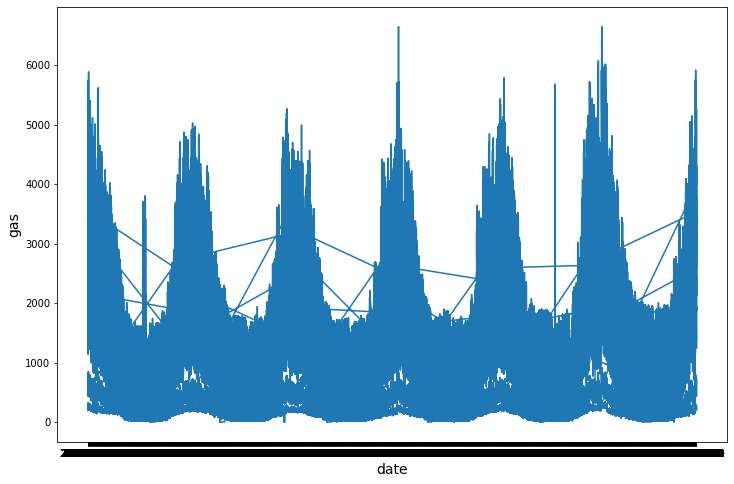

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(train['연월일'], train['공급량'])
plt.ylabel('gas', fontsize=14)
plt.xlabel('date', fontsize=14)
plt.show()

In [ ]:
print(train['구분'].unique())
for x in train['구분'].unique():
  print(x,'공급사 데이터 수', len(train[train['구분'] == x]))

['A' 'B' 'C' 'D' 'E' 'G' 'H']
A 공급사 데이터 수 52584
B 공급사 데이터 수 52584
C 공급사 데이터 수 52584
D 공급사 데이터 수 52584
E 공급사 데이터 수 52584
G 공급사 데이터 수 52584
H 공급사 데이터 수 52584


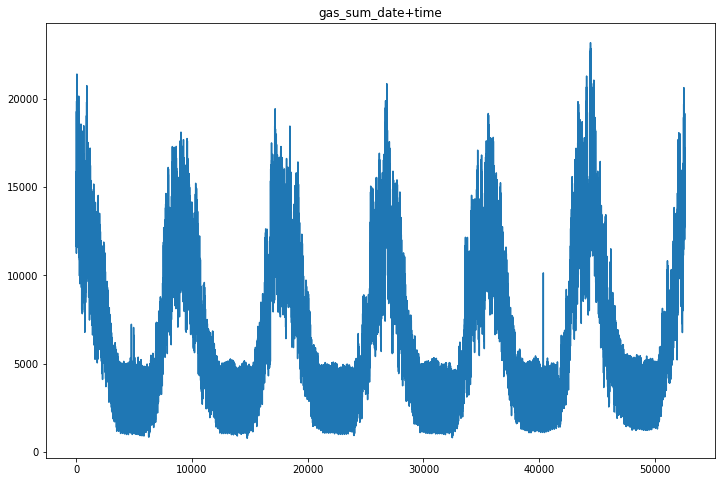

In [ ]:
plt.figure(figsize=(12,8))
gas_sum = train.groupby(['연월일','시간'])['공급량'].sum()
plt.plot(gas_sum.values)
plt.title('gas_sum_date+time')
plt.show()

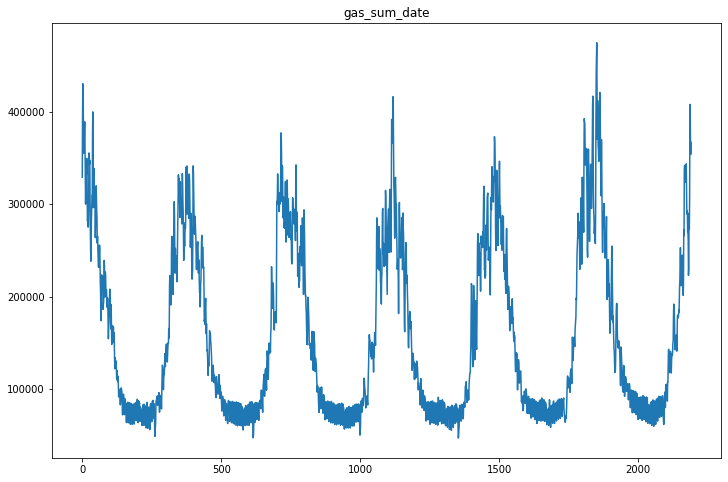

In [ ]:
plt.figure(figsize=(12,8))
gas_sum = train.groupby('연월일')['공급량'].sum()
plt.plot(gas_sum.values)
plt.title('gas_sum_date')
plt.show()

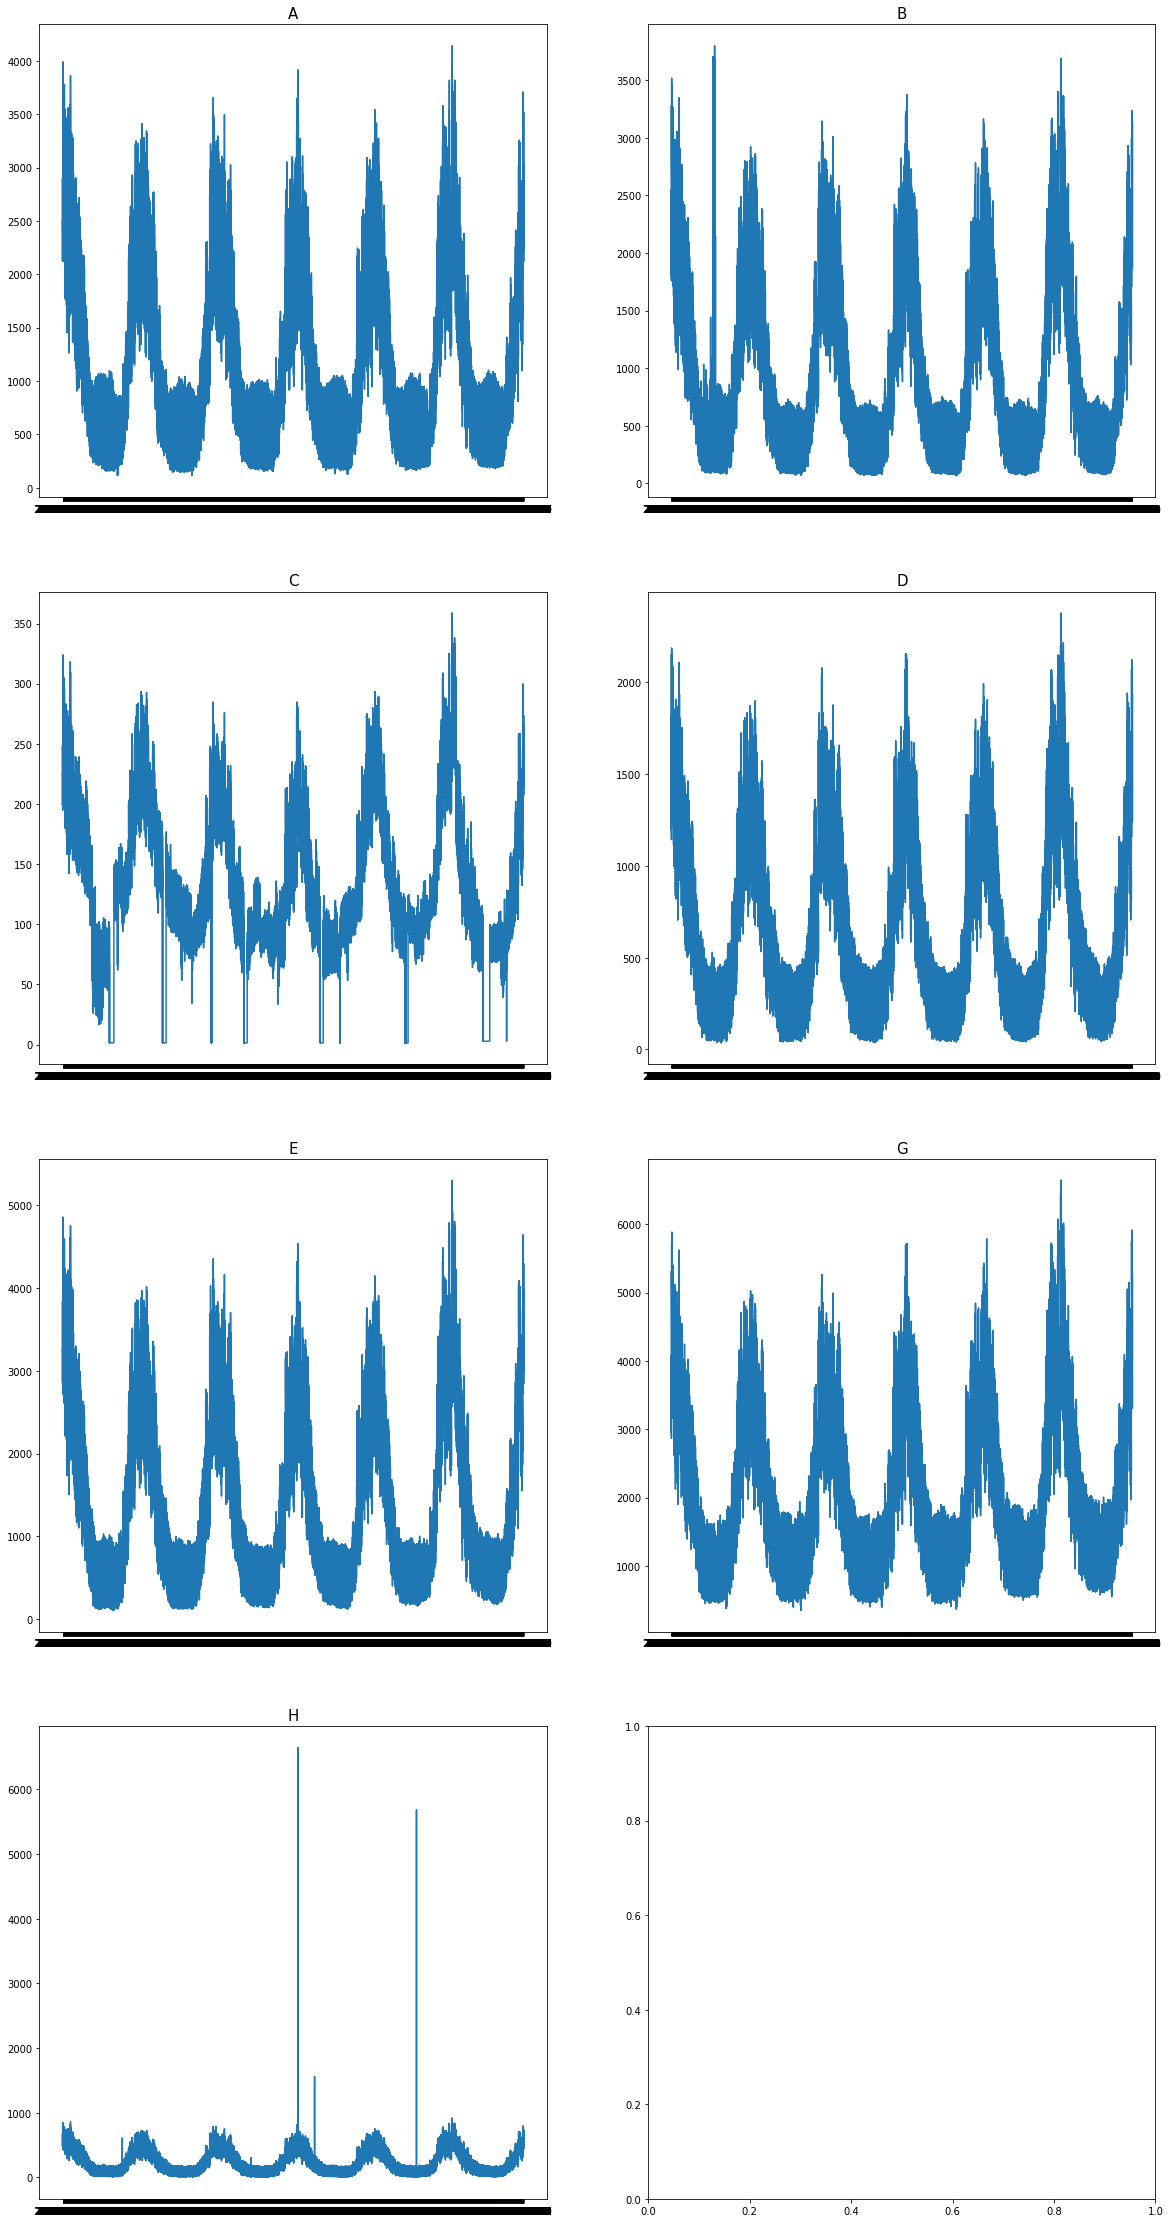

In [ ]:
fig, axes = plt.subplots(4,2, figsize = (20,40))
ax = axes.flatten()

num = 0
for x in train['구분'].unique():
  train_ = train[train['구분'] == x]
  ax[num].plot(train_['연월일'], train_['공급량'])
  ax[num].set_title(x).set_fontsize(15)
  num += 1

In [ ]:
print('공급량이 0인 경우')
display(train[train['공급량'] == 0])

print('\n\n공급량이 10미만 경우')
display(train[train['공급량'] < 10 ])

print('\n\n공급량 10 미만 공급사의 빈도')
train[train['공급량'] < 10 ]['구분'].value_counts()

공급량이 0인 경우


,연월일,시간,구분,공급량




공급량이 10미만 경우


,연월일,시간,구분,공급량
22887,2013-08-12,16,C,1.378
22888,2013-08-12,17,C,1.378
22889,2013-08-12,18,C,1.378
22890,2013-08-12,19,C,1.378
22891,2013-08-12,20,C,1.378
...,...,...,...,...
331090,2018-10-11,11,C,2.756
331091,2018-10-11,12,C,2.756
331092,2018-10-11,13,C,2.756
331093,2018-10-11,14,C,2.756




공급량 10 미만 공급사의 빈도


C    2764
H       2
Name: 구분, dtype: int64

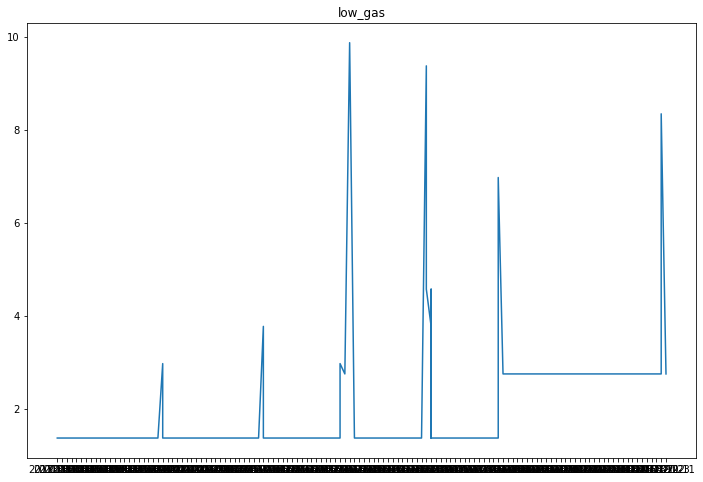

In [ ]:
plt.figure(figsize=(12,8))
low_gas = train[train['공급량'] < 10 ]
plt.plot(low_gas['연월일'], low_gas['공급량'])
plt.title('low_gas')
plt.show()

In [ ]:
low_gas.groupby('연월일')['공급량'].count().sort_values().to_csv('low_gas.csv')

In [ ]:
train[train['공급량']>8000]

,연월일,시간,구분,공급량
2230,2013-04-03,23,A,11593.617
44447,2013-01-27,24,G,10207.077
112751,2014-11-14,24,G,10271.437
174229,2015-11-21,14,G,8086.693
290137,2017-02-07,2,G,8005.709


In [ ]:
# 공급량 8000이상인 것은 이상치로 판단하고 전일의 공급량으로 대체
for row in train[train['공급량']>8000].index:
  train.iloc[row,-1] = train.iloc[(row-1),-1]